<sup>[Back to Table of Contents](0_intro_and_TOC.ipynb/#toc)</sup><a id="interventions"></a>

In [1]:
import oyster as oy

## Examining the Effects of Interventions with Causal Diagrams

We saw in the last section that causal diagrams can be useful tools for interrogating the relationships between variables in a dataset.  But an important class of questions require us to go beyond summarizing the data as it is and instead to ask what *could be*.  Drawing from causal inference's long partnership with medicine and epidemiology, these questions involve ***interventions***, or "what would happen if we did X?" 

### Computing Causal Effects from Observational Data <a id="observational"></a>

As we said in chapter 1; that two variables show a correlation does not imply that one causes the other.  For example, a spurrious correlation can be created between two variables because a third variable is a ***common cause*** for both (heat, in the ice cream-murder correlation discussed earlier).  As we learned in chapter 2, in the causal diagram for this situation (I <- H -> M) heat (H) blocks the only path between ice cream sales (I) and murders commited (M), and thus by conditioning on heat, we render the two variables independent and remove the spurrious correlation.

Now consider a situation like the one below:  Here X stands for the usage of a certain drug, Y for a change in blood pressure, and Z represents Gender.  Suppose that in the general population men are more likely to take the drug than women (due, perhaps, to how the drug was advertised), and that men on average have higher blood pressure.

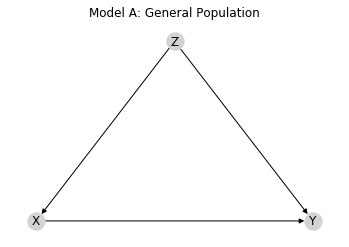

In [2]:
example = oy.CausalDiagram([('X', 'Y'), ('Z', 'X'), ('Z', 'Y')])
ex_pos = {'X': (0,0), 'Y':(2,0), 'Z':(1,1)}
oy.draw(example, pos=ex_pos, title='Model A: General Population')

Both X and Z cause Y, but because Z is a common cause of X and Y, it ***confounds*** the causal effect of X on Y.  How much of X's correlation with Y is due to the causal relationship, and how much is spurious as in the ice cream example?  

Despite the somewhat defeatist label, confounders like Z in this example can be overcome in a few different ways.

One way is to conduct a randomized trial.  We conduct an experiment where the drug is assigned at random to, say, half of the study participants.  By randomizing drug assignment, we are changing the causal model by removing the arrow from Z into X (see the "Interventional Model", below).  We can them simply calculate the average causal effect of X on Y by comparing the average blood pressure for the group receiving the drug to the average blood pressure for the group not receiving it.

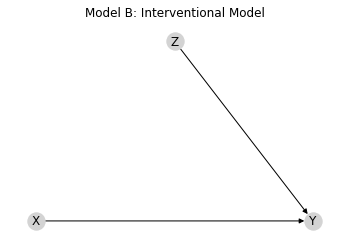

In [3]:
oy.draw(oy.edges_removed(example, [('Z', 'X')]), pos=ex_pos, title='Model B: Interventional Model')

This is all well and good, but getting there involved creating an entirely new dataset, one where we randomly assigned the treatment.  In many cases, either cost or ethical considerations might prevent us from  running such an experiment.

Instead, we'd often like to obtain our causal estimates from ***observational data***, data simply collected, without imposing a treatment assignment.  But an observational dataset on the general population in this example would reflect the propensity for more men to take the drug (its causal diagram would look like model A). We must perform an adjustment on this dataset such that it fits the interventional model. This is done by ***controlling for*** Z: for each level of Z in the data (each gender in this example), we compute the effect of X on Y, and then average these z-specific effects together.  

You might have guessed that controlling for Z was correct procedure for this simple graph, but it's not as clear for more complicated graphs like Figure 3.8.  Which variables ought to be controlled for here in order to determine the causal effect of X on Y?

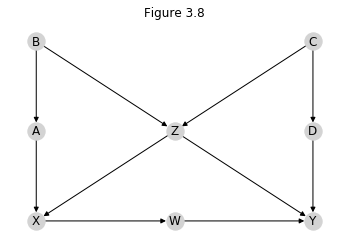

In [4]:
fig3_8 = oy.ex.primer['fig3_8']
oy.draw(fig3_8, title='Figure 3.8')

Fortunately, Oyster implements graphical criteria developed by Judea Pearl and others that can take any causal diagram and determine whether it is possible to determine the effect of X on Y from observational data, and if so, which variables to control for.

### Identifying Adjustment Sets with the Back-Door Criterion <a id="backdoor"></a>

One such procedure is known as the ***Back-door Criterion***.  To satisfy the Back-door Criterion, a set of variables must d-seperate all "backdoor paths" from X to Y (i.e. the paths from X to Y that start with an edge into X, not out of X).  

> #### Study Question 3.3.1 <a id="sq331"></a>
> Consider the graph of Figure 3.8:
> 
> a) List all of the sets of variables that satisfy the backdoor criterion to determine the causal effect of X on Y.

Oyster can check if a given set of variables satisfies the Back-door criterion for a given Causal Diagram using `meets_backdoor_criterion`.  Oyster can also run an exhautive search against all possible sets of variables using `backdoor_criterion_search`.

In [5]:
oy.backdoor_criterion_search(fig3_8, 'X', 'Y')

[{'A', 'Z'},
 {'C', 'Z'},
 {'B', 'Z'},
 {'D', 'Z'},
 {'A', 'C', 'Z'},
 {'A', 'B', 'Z'},
 {'A', 'D', 'Z'},
 {'B', 'C', 'Z'},
 {'C', 'D', 'Z'},
 {'B', 'D', 'Z'},
 {'A', 'B', 'C', 'Z'},
 {'A', 'C', 'D', 'Z'},
 {'A', 'B', 'D', 'Z'},
 {'B', 'C', 'D', 'Z'},
 {'A', 'B', 'C', 'D', 'Z'}]

> b) List all of the *minimal* sets of variables that satisfy the backdoor criterion to determine the causal effect of X on Y.

As in previous examples, use the `minimal_sets` helper function to determine the sets without extraneous variables.

In [6]:
oy.minimal_sets(oy.backdoor_criterion_search(fig3_8, 'X', 'Y'))

[{'A', 'Z'}, {'C', 'Z'}, {'B', 'Z'}, {'D', 'Z'}]

> c) List all minimal sets of variables that need be measured to identify the effect of D on Y.  Repeat, for the effect of {W, D} on Y

In [7]:
oy.minimal_sets(oy.backdoor_criterion_search(fig3_8, 'D', 'Y')) # D on Y

[{'C'}, {'A', 'Z'}, {'B', 'Z'}, {'X', 'Z'}, {'W', 'Z'}]

"The effect of {W, D} on Y" i asking for the effect of certain combinations of W and D on Y.  As with d-separation, Oyster can handle arbitrary sets of cause (or effect) variables, no problem.

In [8]:
oy.minimal_sets(oy.backdoor_criterion_search(fig3_8, {'W', 'D'}, 'Y'))

[{'Z'}, {'C', 'X'}]

Oyster also provides a function `backdoor_adjustment_formula` that generates a Latex expression for the ***Back-Door Adjustment Formula***, which translates from the graphical analysis of specifying a backdoor adjustment set into a symbolic formula for calculating the causal effect from observed data.  The function will also check behind the scenes to confirm the specified adjustment set does indeed meet the backdoor criterion.

In Oyster's notation, a P with a subscript indicates an interventional probability, and lower case letters represent specific values of the upper case variables.  So: $P(Y = y | do(X=x)) = P_{x}(y)$.

You can view the Latex expression in a Jupyter notebook by importing `Math` from `IPython.display`. 

So for an expression of the causal effect of {W, D} on Y, we supply `backdoor_adjustment_formula` with one of the minimal sets returned by `backdoor_criterion_search`, in this case the single control variable 'Z'.

In [9]:
from IPython.display import Math
Math(oy.backdoor_adjustment_formula(fig3_8, {'W', 'D'}, 'Y', 'Z'))

<IPython.core.display.Math object>

### Justifying Adjustment Procedures with Causal Diagrams<a id="arg"></a>

We saw above that the Back-door Criterion justifies the application of a statistical adjustment on a dataset to determine causal effects. The below example, based on a classic statistical paradox, showcases the utility of causal diagrams for ***causal argumentation***, because causal diagrams make explicit the assumptions behind a given adjustment procedure.  

> #### Study Question 3.3.2 (Lord's Paradox) <a id="sq332"></a>

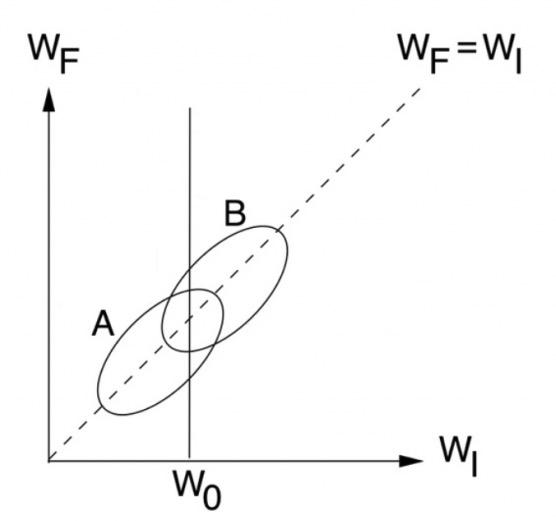

In [10]:
from IPython.display import Image
Image('images/lords_paradox.png', width=300)
# Image Credit: Judea Pearl (http://causality.cs.ucla.edu/blog/index.php/2019/08/13/lords-paradox-the-power-of-causal-thinking/)

>   A boarding school offers two meal plans over a school year: Plan A, and Plan B.  The students' initial weight $W_{I}$ and final weights $W_{F}$ are recorded. To determine how each plan affects students' weight gain, the school hires two statisticians who, oddly, reach different conclusions.  
>
> The first statistician calculates $W_{F} - W_{I}$ for each student and finds that the average weight gain in each plan was zero. This can be seen in the figure by noting that the ovals representing the spread of weight measurements are symmetric around the line $W_{F} = W_{I}$.
>
> The second statistician subdivides the students into several subgroups by initial weight. For each individual weight, the final weight is higher for Plan B than the final weight for Plan A.  I.e., for any choice of $W_{I} = W_{0}$ in the figure, the average $W_{F}$ for dining Plan B is more than the average $W_{F}$ for dining Plan A.
>
> The first statistician thus concludes that there was no effect of diet on weight gain and the second statistician concludes that plan B caused students to gain more weight.
>
> #### Which statistician is right?  How can it be that two statisticians can reach two different conclusions about the same data?

The difference in conclusions stems from the fact that statistician 1 did not control for initial weight, whereas statistician 2 did.  Each statistician made an impicit assumption about the causal relationships between the variables in the study, and performed the correct adjustment associated with that assumption.  

If forced to draw a causal graph representing his model, Statistician 1 might have drawn any of the following three models to justify the choice not to control for Wi.  In each graph, Wi is not on a backdoor path from Plan to Wf.  The Back-door criterion is satisfied without controlling for Wi, so no adjustment is necessary and (according to Statistician 1) the correct procedure is simply to calculate the average change in weight for the population as a whole.

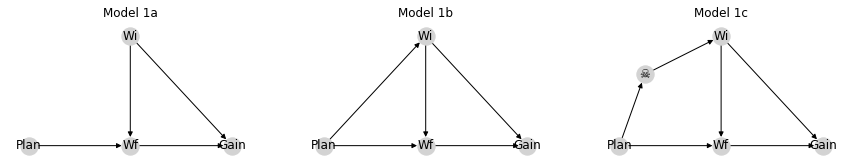

In [11]:
model1a = oy.CausalDiagram([('Wi', 'Wf'), ('Plan', 'Wf'), ('Wi', 'Gain'), ('Wf', 'Gain')])
model1b = oy.CausalDiagram([('Wi', 'Wf'), ('Plan', 'Wf'), ('Plan', 'Wi'), ('Wi', 'Gain'), ('Wf', 'Gain')])
model1c = oy.CausalDiagram([('Wi', 'Wf'), ('Plan', 'Wf'), ('Plan', '☠'), ('☠', 'Wi'), ('Wi', 'Gain'), ('Wf', 'Gain')])

lords_pos ={'Plan': (0,0), 'Wi': (1,1), 'Wf': (1,0), 'Gain': (2,0), '☠': (.25, .65), 'Eating Habits': (.25, .65)}
import matplotlib.pyplot as plt

fig1, axs1 = plt.subplots(1,3, figsize=(15,2.5))
oy.draw(model1a, pos=lords_pos, title='Model 1a', ax=axs1[0])
oy.draw(model1b, pos=lords_pos, title='Model 1b', ax=axs1[1])
oy.draw(model1c, pos=lords_pos, title='Model 1c', ax=axs1[2])

However, none of these graphs are particularly plausible.  Model 1a implies that the meal plan was unrelated to Wi, (or, equivalently, that it was assigned at random), but from the data we can clearly see that the populations that received meal plan A differed from the population that received plan B in terms of Wi.  Model 1b stipulates that plan assignment caused initial weight, which is hard to imagine except possibly in a scenario like model 1c, where plan assignment had an effect on initial weight via some intermediary; perhaps a bout of food poisoning (represented by node '☠' on the graph, did I mention that Oyster can take arbitrary labels for nodes, including unicode symbols?) caused those in plan A to lose lots of weight immediately before the initial weight measurement.  So it's *possible* to contort a model that justifies not controlling for Wi, but once laid bare, Statistician 1's assumptions can be checked against data and expert knowledge.

The second statistician could draw graphs such as the two below to justify adjusting for Wi:

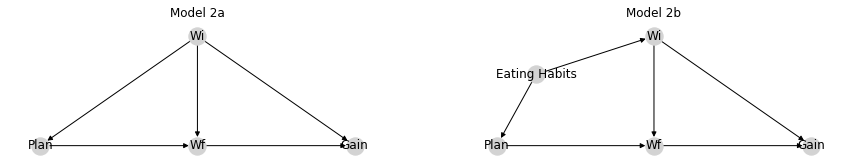

In [12]:
model2a = oy.CausalDiagram([('Wi', 'Wf'), ('Wi', 'Plan'), ('Plan', 'Wf'), ('Wi', 'Gain'), ('Wf', 'Gain')])
model2b = oy.CausalDiagram([('Wi', 'Wf'), ('Eating Habits', 'Plan'), ('Eating Habits', 'Wi'), ('Plan', 'Wf'), ('Wi', 'Gain'), ('Wf', 'Gain')])

fig2, axs2 = plt.subplots(1,2, figsize=(15,2.5))
oy.draw(model2a, pos=lords_pos, title='Model 2a', ax=axs2[0])
oy.draw(model2b, pos=lords_pos, title='Model 2b', ax=axs2[1])

These models stipulate that the students' meal plan assignment was either directly influenced by their initial weight, or a confounder introduced a selection bias into which children recieved which plan: perhaps children chose their own meal plans, and those with poor eating habits were more likely to choose meal plan B while also being more likely to have a higher initial weight.  In these cases Wi is on a backdoor path (actually two backdoor paths) from Plan to Gain, and thus controlling for Wi satisfies the backdoor criterion, justifying Statistician 2's procedure of averaging weight gains only after first calculating the average gain across initial weight classes (i.e. "controlling for Wi"). 

Either of statistician 2's models seems more plausible than the models fitting the procedure followed by statistician 1 based on what we know from the example, but more importantly, the models provide a common language in which to explicitly reason about, argue for, and explain their chosen assumptions.

**Bonus**: As an exercise to the reader, imagine a different scenario where a school wants to determine whether the single meal plan it offers in its cafeteria has different effects on girls vs. boys.  The data are arrayed just as in the above figure, but A and B represent girls and boys, as opposed to the students assigned to different meal plans.  By drawing causal graphs one should see that in this case the most convincing argument is in favor of *not* adjusting for Wi, and thus conclude that the single meal plan does not affect girls and boys differently.

### Identifying Adjustment Sets with the Front-Door Criterion  <a id="frontdoor"></a>

In some causal diagrams, it may not be possible to perform Back-Door Adjustment.  Consider this classic example: up until 1970, the tobacco industry promoted the idea that the established correlation between smoking and lung cancer could be explained away by an as-yet undiscovered genetic factor that caused both a greater propensity for smoking (say, an elevated craving for nicotine) and also a greater genetic risk of developing lung cancer.  The causal diagram for this is the same as in model A above, except this time the confounding element is not observable. Since the genetic factor was unobservable, it couldn't be controlled for (conveniently for the tobacco lobby).

However, suppose we had access to additional data on the presence of tar deposits in patients' lungs. A causal model proposing that smoking ('X') causes tar deposits ('T') causes lung cancer ('Y') would be described by the following causal diagram (with 'U' as the unobservable proposed genetic factor).

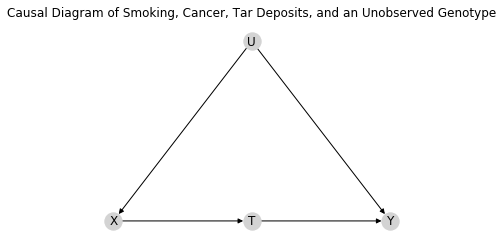

In [13]:
smoking_example = oy.CausalDiagram([('X', 'T'), ('U', 'X'), ('U', 'Y'), ('T', 'Y')])
smoking_ex_pos = {'X': (0,0), 'Y':(2,0), 'U':(1,1), 'T': (1,0)}
oy.draw(smoking_example, pos=smoking_ex_pos, title='Causal Diagram of Smoking, Cancer, Tar Deposits, and an Unobserved Genotype')

We're still out of luck when it comes to the Back-Door Criterion.  'U' is still on the back-door path from X to Y, and it can't be controlled for.  

**However**, note that that because U does not affect T, we can determine the effect of X on T.  There are no confounders for that relationship; any change in T is due entirely to a change in X.

Now look at the effect of T on Y.  It might help to plot the nodes on this graph differently, but since we keep the orientation of the arrows the same, the graph below is for all intents and purposes the same as the graph above. In fact, in the code note that Oyster simply plots the same causal diagram using different positions.

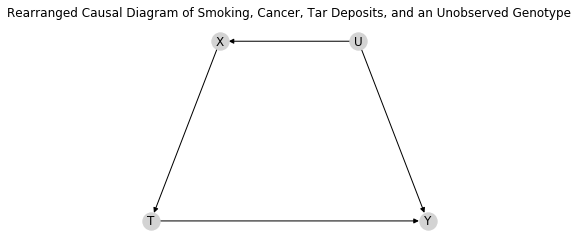

In [14]:
smoking_ex_pos = {'X': (.5,1), 'Y':(2,0), 'U':(1.5,1), 'T': (0,0)}
oy.draw(smoking_example, pos=smoking_ex_pos, title='Rearranged Causal Diagram of Smoking, Cancer, Tar Deposits, and an Unobserved Genotype')

It should be clear that the effect of T on Y is also identifiable - while it has a backdoor path, the path can be blocked by controlling for X!

It should be intuitive that because we can identify the affect of X on T and of T on Y, we can therefore calculate the affect of X on Y in this case. 

Pearl and others have shown that the above logic can be used to calculate causal effects from observational idea in any situation where the following ***Front-Door Criterion*** holds:

A set of variables Z satisfies the effect of X on Y if:

1. Z intercepts all directed paths from X to Y.
1. There is no backdoor path from X to Z.
1. All backdoor paths from Z to Y are blocked by X.

Readers can satisfy themselves that 'T' satisfies the Front-Door Criterion for the effect of X on Y in the above example. 

> #### Study Question 3.4.1 <a id="sq341"></a>
> Assume that in Figure 3.8, only X, Y, and one additional variable can be measured.  Which variable would allow the identification of the effect of X on Y? What would that effect be?

Recalling from Study Question 3.3.1, all the minimal adjustment sets that satisfy the backdoor criterion have at least two variables, Z and either A, B, C, or D.  So instead, let's look for front-door adjusters.

Similar to back-door adjustment, Oyster provides functions `meets_frontdoor_criterion` `frontdoor_criterion_search`, to verify and search for front-door adjustment sets, respectively.

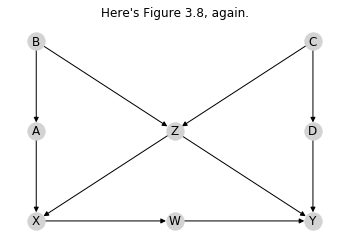

In [15]:
oy.draw(fig3_8, title="Here's Figure 3.8, again.")

In [16]:
oy.frontdoor_criterion_search(fig3_8, 'X', 'Y')

[{'W'}]

'W' meets the Front-Door criterion, and thus provides a way to estimate the causal effect of X on Y from a single variable.

Oyster also provides the Latex expression of the formula for front-door adjustment with `frontdoor_adjustment_formula`.

For a set Z satisfying the front-door criterion for the effect of X on Y, the ***Front-Door Adjustment Formula*** can be derived via two applications of the backdoor adjustment formula, once for the effect of X on Z (adjusting on the null set because in satisfying the front-door criterion we stipulate there is no backdoor path), and again for the effect of Z on Y, adjusting for X: 

In the case of this example, choosing 'W' as our front-door adjustment set:

In [17]:
Math(oy.frontdoor_adjustment_formula(fig3_8, 'X', 'Y', 'W'))

<IPython.core.display.Math object>

Here $x'$ is just an index of summation: the second term of the formula should be summed over all states of X.

### Specific Effects as Multipurpose Tool for Analysis <a id="specific"></a>

Sometimes the relevant policy question pertains to an effect that is specific to the state of another covariate. That is, the causal effect of X on Y, conditioning on C.   The process for finding  ***specific effects*** <a id="specificEffects"></a> involves simply finding a valid adjustment set that includes C. 

Specific effects have at several important uses in causal inference:

1. Computing specific effects are an essential step in examining ***effect modification or moderation***.  A policy question might revolve around the effect of X on Y for a specific subpopulation with characteristics W = w.  Another policy question might ask how the effect of X on Y changes if W changes from w to w'.
2. When a policy under evaluation involves a ***dynamic or conditional intervention***, where the value of X changes based on the value of some set of other covariates Z (e.g. age, weight, etc.).  The act of varying X as a function of Z amounts to conditioning on Z, and thus the effect of X on Y is a Z-specific effect.
3. Comparing causal effects from different adjustment sets (i.e. different specific effects) is another ***testable constraint*** on model, in addition to the implied independencies discussed earlier.  The effect of X on Y should ideally be the same no matter our choice of Z (provided each Z satisfies a criterion for identifiability).  When the calculated specific causal effects differ significantly, it should call the validty of the model into question. 

> #### Study question 3.5.1 <a id="sq351"></a>
> Continuing with Figure 3.8...
> 
> a) Find an expression for the c-specific effect of X on Y.

In Oyster, finding a specific adjustment set can be done with a simple filter or conditional list comprehension:

In [18]:
[s for s in oy.backdoor_criterion_search(fig3_8, 'X', 'Y') if 'C' in s]

[{'C', 'Z'},
 {'A', 'C', 'Z'},
 {'B', 'C', 'Z'},
 {'C', 'D', 'Z'},
 {'A', 'B', 'C', 'Z'},
 {'A', 'C', 'D', 'Z'},
 {'B', 'C', 'D', 'Z'},
 {'A', 'B', 'C', 'D', 'Z'}]

Oyster also provides a `specific_adjustment_sets` function that does the same thing.  Let's also just pick out the minimal sets:

In [19]:
oy.minimal_sets(oy.specific_adjustment_sets(fig3_8, 'X', 'Y', 'C'))

[{'C', 'Z'}]

The expression for calculating the z-specific effect is a slight modification of the backdoor adjustment formula, which amounts to separating Z out from the other adjustment variables S as a conditional.  But in any case, the set $Z \cup S$ (all variables in Z as well as all variables in S) must satisfy the backdoor criterion.  Oyster checks this condition and outputs the appropriate Latex with `specific_adjustment_formula`, which in addition to parameters for the causal diagram, X, Y, and Z, also requires S, the set of any variables in addition to Z necessary to satisfy the backdoor criterion.  

In this example, for the c-specific effect, we input 'C' for the specific effect variable, and 'Z' for the other variables necessary to satisfy the back-door criterion.

In [20]:
Math(oy.specific_adjustment_formula(fig3_8, 'X', 'Y', 'C', 'Z'))

<IPython.core.display.Math object>

> b) Identify a set of four variables that need to be measured in order to estimate the z-specific effect of X on Y, and find an expression for the size of that effect.

Let's filter the `specific_adjustment_sets` for 'Z' to just those containing four elements:

In [21]:
sets = [s for s in oy.specific_adjustment_sets(fig3_8, 'X', 'Y', 'Z') if len(s) == 4]
for s in sets: print(s)

{'Z', 'A', 'B', 'C'}
{'Z', 'A', 'D', 'C'}
{'Z', 'A', 'B', 'D'}
{'Z', 'B', 'D', 'C'}


And again using `specific_adjustment_formula` to give an expression for one of those sets:

In [22]:
Math(oy.specific_adjustment_formula(fig3_8, 'X', 'Y', 'Z', sets[0] - {'Z'}))

<IPython.core.display.Math object>

## Instrumental Variables and Research Design<a id="iv"></a> 

Back-door and Front-door adjustment are two ways of determining the effect of X on Y in a causal model from observational data, but it is not always possible to find variables that meet the back- or front-door criteria, particularly when certain potential confounders are not observable.  Fortunately there are still more ways to identify a causal effects. One common approach is to search a causal diagram for ***instrumental variables***.

Consider this graph and its front and backdoor adjustment sets:

Back-Door Adjustment Sets: [{'U'}, {'Z', 'U'}]
Front-Door Adjustment Sets: []


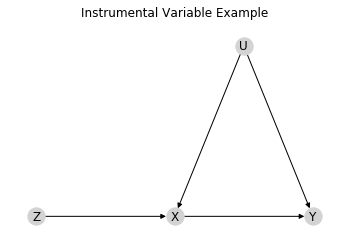

In [23]:
iv = oy.CausalDiagram([('Z', 'X'), ('X', 'Y'), ('U', 'X'), ('U', 'Y')])
iv_pos = {'Z': (0,0), 'X': (1,0), 'Y': (2,0), 'U': (1.5, .5), 'W': (2,1)}
oy.draw(iv, pos=iv_pos, title='Instrumental Variable Example')

print(f"Back-Door Adjustment Sets: {oy.backdoor_criterion_search(iv, 'X', 'Y')}")
print(f"Front-Door Adjustment Sets: {oy.frontdoor_criterion_search(iv, 'X', 'Y')}")

For the effect of X->Y, there are no front-door adjusters, and both back-door adjustment sets include U.  Suppose U is unobservable (or U represents a suspected but unmeasurable common cause of X and Y, like the "smoking gene" theory promoted by the tobacco industry).  Are we out of luck?  It turns out that, *under certain assumptions*, the answer is no!

Note that there are no backdoor paths from Z to X, nor are there any from Z to Y.  So those effects can be identified directly.  In this case Z can be called an *instrumental variable* relative to the effect of X on Y.

**If the relationships between X, Y, and Z are assumed to be linear**, then the causal effect of X on Y is simply the regression coefficent of Y on Z divided by the regression coefficient of X on Z.  

In the nonlinear case, one can't simply take the ratio of coefficients, but under assumptions of ***monotonicity*** and ***exogeneity***, it might still be possible to calculate the effect of X on Y, or at least bound it.

Sometimes a variable might serve as an instrument conditional on some other set of variables.  Consider this graph:

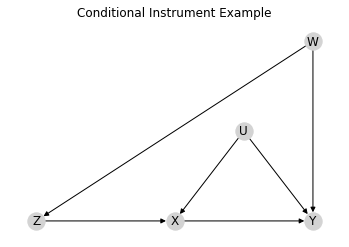

In [24]:
conditional_iv = oy.CausalDiagram([('Z', 'X'), ('X', 'Y'), ('U', 'X'), ('U', 'Y'), ('W', 'Z'), ('W', 'Y')])

oy.draw(conditional_iv, pos=iv_pos, title='Conditional Instrument Example')

Here there is a backdoor path from Z to Y, but if W is observable, that backdoor path can be blocked. So Z can be used as an instrument for determining X and Y, if we condition on W.

In general, Z is an instrumental variable, conditional on W if:
- Z and X *are not* d-separated by W,
- Z and Y *are* d-separated by W, and
- No nodes in W are descendants of Y (if they were, the graph would contain a collider that opens a path from Z to Y).

Oyster can help identify instrumental variables in a causal diagram using `instrumental_variable_search` which returns all instrumental variables and their associated minimal conditioning sets.  When designing an experiment or data collection procedure for which direct back- or front-door adjustment won't be possible, conducting an instrumental variable analysis ahead of time can help define what additional data should be collected to serve as an instrumental variable.

For complicated graphs, it may be too computationally intensive to perform an exhaustive search; `ancestral_instrument_search` is a faster algorithm that guarantees finding an instrument if one exists, although the conditioning set may not be minimal.

Both functions return a tuple of the instrumental variable and its conditioning set (or the empty set if it is a pure instrumental variable).

In [25]:
print(f"IV for Instrumental Variable Example: {oy.instrumental_variable_search(iv, 'X', 'Y')}")
print(f"IV for Conditional Instrument Example: {oy.instrumental_variable_search(conditional_iv, 'X', 'Y')}")

IV for Instrumental Variable Example: [('Z', [set()])]
IV for Conditional Instrument Example: [('Z', [{'W'}])]


## General Identifiability <a id="id"></a>

Lacking observable adjustment variables or instrumental variables, Pearl and several coauthors have developed a more general criteria that can determine conclusively if the causal effect in a given diagram can be estimated from observational data.  These methods are complete: if it is possible to identify a causal effect, they will say so.  

Oyster has a function `is_identifiable` that implements the general graphical criteria developed by Pearl and his colleagues (particularly Jian Tian and Ilya Shpitser). Oyster currently implements the algorithm insofar as it returns whether a graph is or is not identifiable; an extension is under development that outputs the appropriate adjustment formula.

The following graphs can be shown to be *not* identifiable for X -> Y when nodes starting with U are unobservable.

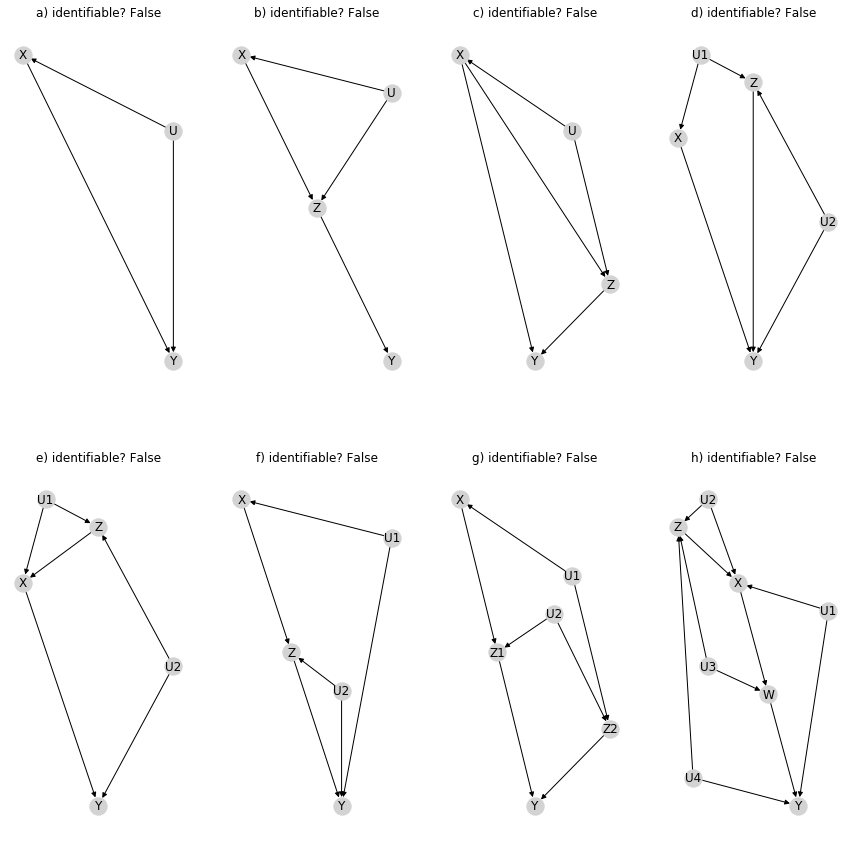

In [26]:
fig1, axs = plt.subplots(2,4, figsize=(15,15))
for i, (name, DAG) in enumerate(oy.ex.sp08['fig1'].items()):
    oy.draw(DAG, 
            title=f'{name}) identifiable? {oy.is_identifiable(DAG, "X", "Y")}',
            ax=axs.flatten()[i])

Whereas the following graphs are identifiable, even with 'U' nodes unobserable:

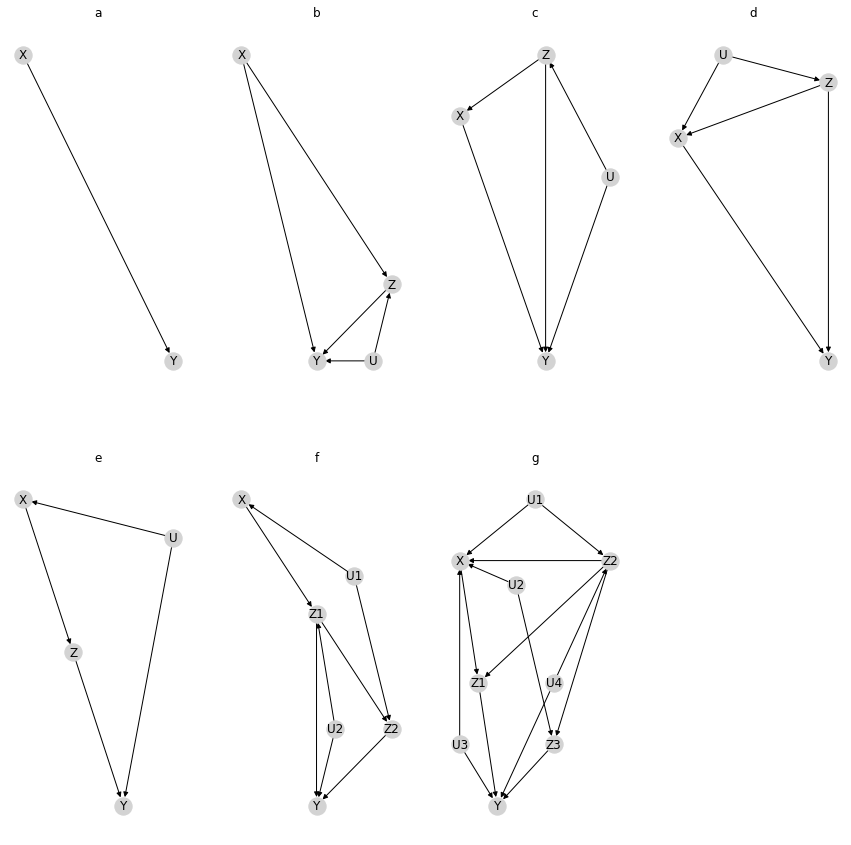

In [27]:
fig1, axs = plt.subplots(2,4, figsize=(15,15))
for ax, (name, DAG) in zip(axs.flatten(), oy.ex.sp08['fig2'].items()):
    oy.draw(DAG, 
            title=f'{name}',
            ax=ax)
axs[1][3].set_axis_off()

Some of these have backdoor adjusters, some frontdoor adjusters, (none have instrumental variables), but note that graphs f and g are still identifiable dispite not having any instrumental variables nor observable variables fitting the backdoor criterion or frontdoor criterion.

The do-calculus and it's graphical corrolary are able to capture this larger, complete class of identifiable graphs, illuminating all possible paths to identifying causal effects from a given model.

In [28]:
for name, DAG in oy.ex.sp08['fig2'].items():
    hidden_vars =  {'U', 'U1', 'U2', 'U3', 'U4'} 
    ba_wo_U = [s for s in oy.backdoor_criterion_search(DAG, 'X', 'Y') 
               if not hidden_vars & s]
    
    fa_wo_U = [s for s in oy.frontdoor_criterion_search(DAG, 'X', 'Y') 
               if not hidden_vars & s]
    print(f'-------\nGraph {name}\n-------')
    print(f'Observable Backdoor adjustment sets: {ba_wo_U}')
    print(f"Observable Frontdoor adjustment sets: {fa_wo_U}")
    print(f"Instrumental variables: {oy.instrumental_variable_search(DAG, 'X', 'Y')}")
    print(f"Identifiable? {oy.is_identifiable(DAG, 'X', 'Y')}")

-------
Graph a
-------
Observable Backdoor adjustment sets: [set()]
Observable Frontdoor adjustment sets: []
Instrumental variables: []
Identifiable? True
-------
Graph b
-------
Observable Backdoor adjustment sets: [set()]
Observable Frontdoor adjustment sets: []
Instrumental variables: []
Identifiable? True
-------
Graph c
-------
Observable Backdoor adjustment sets: [{'Z'}]
Observable Frontdoor adjustment sets: []
Instrumental variables: []
Identifiable? True
-------
Graph d
-------
Observable Backdoor adjustment sets: [{'Z'}]
Observable Frontdoor adjustment sets: []
Instrumental variables: []
Identifiable? True
-------
Graph e
-------
Observable Backdoor adjustment sets: []
Observable Frontdoor adjustment sets: [{'Z'}]
Instrumental variables: []
Identifiable? True
-------
Graph f
-------
Observable Backdoor adjustment sets: []
Observable Frontdoor adjustment sets: []
Instrumental variables: []
Identifiable? True
-------
Graph g
-------
Observable Backdoor adjustment sets: []
Obser

## Up Next...Counterfactuals

You've now learned how Causal Diagrams can be searched for covariates meeting specific criteria that allow for the calculation of causal effects, with implications for the formation and evaluation of a specific policy.  In the [next section](4_counterfactuals.ipynb) we extend the idea of identifying what *could be*, to what *might have been*, the foundations of the concepts of blame and regret that underlie other important questions in policy and law.